In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('acc.csv')

In [3]:
df.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,...,False,False,False,False,True,False,Day,Day,Day,Day


In [4]:
#Only using accidents reported from 'MapQuest', as different sources tend to have different opinions about the 'severity' of the accident.
df = df[df.Source=="MapQuest"]
df = df.drop(columns=['Source'])

In [5]:
#Removing features that are not required
df=df.drop(columns=['ID','TMC','Description','Distance(mi)','Start_Time','End_Time','End_Lat','End_Lng','Country','Turning_Loop','Weather_Timestamp','Number','Wind_Chill(F)','Bump','Give_Way','No_Exit','Roundabout','Traffic_Calming','Street', 'City', 'County', 'Zipcode', 'Airport_Code'])

In [6]:
#Replacing missing values in 'Precipitation(in)' with the median value
df['Precipitation(in)'] = df['Precipitation(in)'].fillna(df['Precipitation(in)'].median())

In [7]:
#Dropping the rows where any one of the below features are NA as the count of missing values are very low in these features
df = df.dropna(subset=['Sunrise_Sunset','Civil_Twilight','Nautical_Twilight','Astronomical_Twilight',
                      'Temperature(F)','Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)',
                      'Wind_Direction','Weather_Condition'])

In [8]:
#Severity Level 4 is condsidered as High Severity accident and the rest of the Levels are considered as Low Severity accident
df['Severity4'] = 1
df.loc[df['Severity']!=4,'Severity4'] = 0
df = df.drop(['Severity'],axis=1)

In [9]:
# One-hot encode categorical features
df = df.replace([True, False], [1,0])
categorical_data = ['Side','State','Timezone','Wind_Direction','Weather_Condition']
df[categorical_data] = df[categorical_data].astype('category')
df = pd.get_dummies(df, columns=categorical_data, drop_first=True)

In [10]:
df = df.replace(['Day','Night'], [1,0])

In [11]:
df['Severity4'].value_counts()

0    2049335
1       6281
Name: Severity4, dtype: int64

In [12]:
##The dataset is severely skewed in the distribution of severity4 (ratio of 1:326)
#Therefore we oversample(duplicate random entries) the minority class and undersample(delete random entries) the majority class
df_bl = pd.concat([df[df['Severity4']==1].sample(40000, replace = True),df[df['Severity4']==0].sample(40000)],axis=0)

In [13]:
#Train Test Split
X = df_bl.drop(columns=['Severity4'])
y= df_bl['Severity4']

from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)

# split train test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [14]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

accuracy_train = model.score(X_train, y_train)
print("Train Accuracy: %f"% (accuracy_train*100))
accuracy_lg = model.score(X_test,y_test)
print("Test Accuracy: %f"% (accuracy_lg*100))

Train Accuracy: 78.321875
Test Accuracy: 78.475000


In [15]:
from sklearn.metrics import f1_score, recall_score, precision_score

pred = model.predict(X_test)
recall_lg = recall_score(y_test, pred)
precision_lg = precision_score(y_test,pred)
print("Recall : ",recall_lg)
print("F1 Score : ",f1_score(y_test, pred))
print("Precision Score : ",precision_lg)

Recall :  0.8061276379354183
F1 Score :  0.7864318491876473
Precision Score :  0.7676755447941889


In [16]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import tree
param_grid = {'max_depth': [2, 4, 6, 8]}
DT = GridSearchCV(DecisionTreeClassifier(random_state=0),param_grid)
DT.fit(X_train, y_train)

# Training step, on X_train with y_train
model = tree.DecisionTreeClassifier(min_samples_split = 5)
model = model.fit(X_train,y_train)

accuracy_train = model.score(X_train, y_train)
print("Train Accuracy: %f"% (accuracy_train*100))
accuracy_dt = model.score(X_test,y_test)
print("Test Accuracy: %f"% (accuracy_dt*100))

Train Accuracy: 99.773438
Test Accuracy: 94.137500


In [17]:
pred = model.predict(X_test)
recall_dt = recall_score(y_test, pred)
precision_dt = precision_score(y_test,pred)
print("Recall : ",recall_dt)
print("F1 Score : ",f1_score(y_test, pred))
print("Precision Score : ",precision_dt)

Recall :  0.9897025171624714
F1 Score :  0.9431790646959051
Precision Score :  0.9008331404767415


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
param_grid = {}
model = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid,cv=4)
model.fit(X_train, y_train)

accuracy_train = model.score(X_train, y_train)
print("Train Accuracy: %f"% (accuracy_train*100))
accuracy_rf = model.score(X_test,y_test)
print("Test Accuracy: %f"% (accuracy_rf*100))

Train Accuracy: 100.000000
Test Accuracy: 96.818750


In [19]:
pred = model.predict(X_test)
recall_rf = recall_score(y_test, pred)
precision_rf = precision_score(y_test,pred)
print("Recall : ",recall_rf)
print("F1 Score : ",f1_score(y_test, pred))
print("Precision Score : ",precision_rf)

Recall :  0.9970760233918129
F1 Score :  0.9685705464649584
Precision Score :  0.9416496578220674


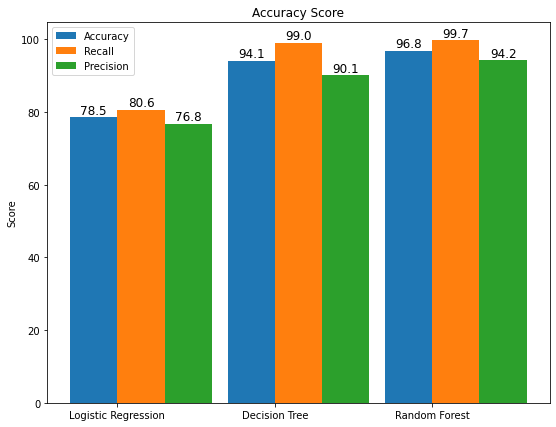

In [20]:
N = 3
plt.subplots(figsize=(9,7))
accuracy = [accuracy_lg, accuracy_dt, accuracy_rf]
recall = [recall_lg, recall_dt, recall_rf]
precision = [precision_lg, precision_dt, precision_rf]

for i in range(len(accuracy)):
    accuracy[i] = round(accuracy[i]*100,1)

for i in range(len(recall)):
    recall[i] = round(recall[i]*100,1)

for i in range(len(precision)):
    precision[i] = round(precision[i]*100,1)

accuracy, recall, precision = tuple(accuracy), tuple(recall), tuple(precision)
ind = np.arange(N) 
width = 0.3
plt.bar(ind, accuracy, width, label='Accuracy')
plt.bar(ind + width, recall, width, label='Recall')
plt.bar(ind + 2*width, precision, width, label='Precision')

plt.ylabel('Score')
plt.title('Accuracy Score')

plt.xticks(ind + width / 2, ('Logistic Regression', 'Decision Tree', 'Random Forest'))
plt.legend(loc='best')
for index,data in enumerate(accuracy):
    plt.text(x=index, y =data+1, s=f"{data}", fontdict=dict(fontsize=12), ha='center')

for index,data in enumerate(recall):
    plt.text(x=index+width, y =data+1, s=f"{data}", fontdict=dict(fontsize=12), ha='center')

for index,data in enumerate(precision):
    plt.text(x=index+2*width, y =data+1, s=f"{data}", fontdict=dict(fontsize=12), ha='center')
plt.show()